In [35]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
# we are going to do whole inference, so no resizing of the image
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [36]:
import cv2

image=cv2.imread("/media/bikram/ext_ssd_2t/Siyu_BIkram/MFN_Failure_set/iced/ice00129D_rgb.png")


In [37]:


pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
     

print(pixel_values.shape)
     


torch.Size([1, 3, 480, 640])


In [38]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [39]:
import torch

# Define the function to enable dropout during inference
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

# Define the function to perform multiple stochastic forward passes
def mc_forward_passes(model, pixel_values, n_passes=30):
    model.eval()
    enable_dropout(model)
    
    predictions = []
    with torch.no_grad():
        for _ in range(n_passes):
            outputs = model(pixel_values)
            logits = outputs.logits
            predictions.append(logits.unsqueeze(0))
    
    predictions = torch.cat(predictions, dim=0)
    return predictions

# Define the function to calculate uncertainty metrics
def calculate_uncertainty(predictions):
    mean_prediction = predictions.mean(dim=0)
    variance = predictions.var(dim=0)
    probs = torch.softmax(predictions, dim=2)
    mean_probs = probs.mean(dim=0)
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
    
    return mean_prediction, variance, entropy

# Load your model and input data
# model = ... (your Segformer model)
# pixel_values = ... (your input tensor)

# Perform MC dropout inference
predictions = mc_forward_passes(model, pixel_values, n_passes=60)

# Calculate uncertainty
mean_prediction, variance, entropy = calculate_uncertainty(predictions)

# Now you can use mean_prediction, variance, and entropy for further analysis


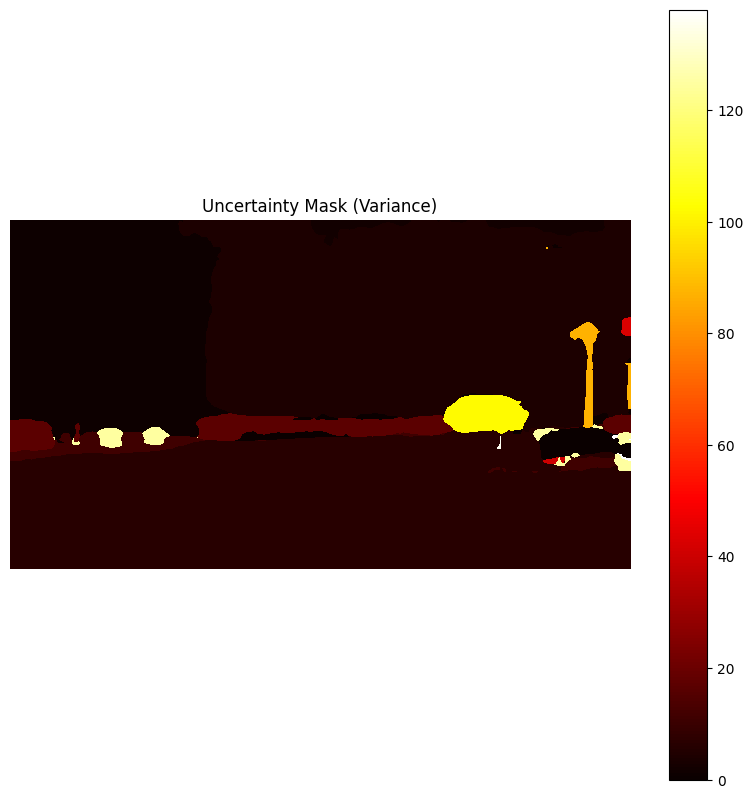

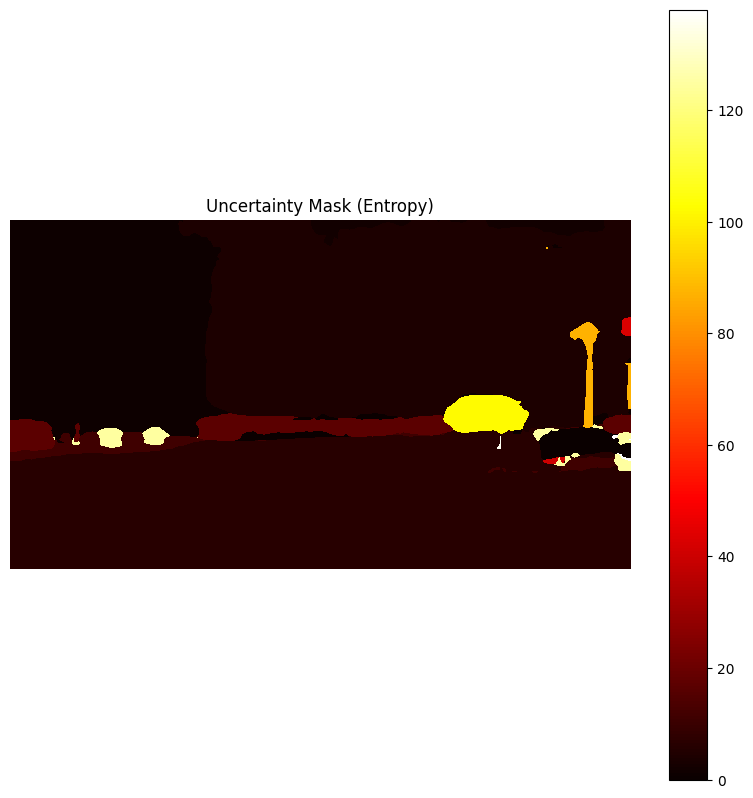

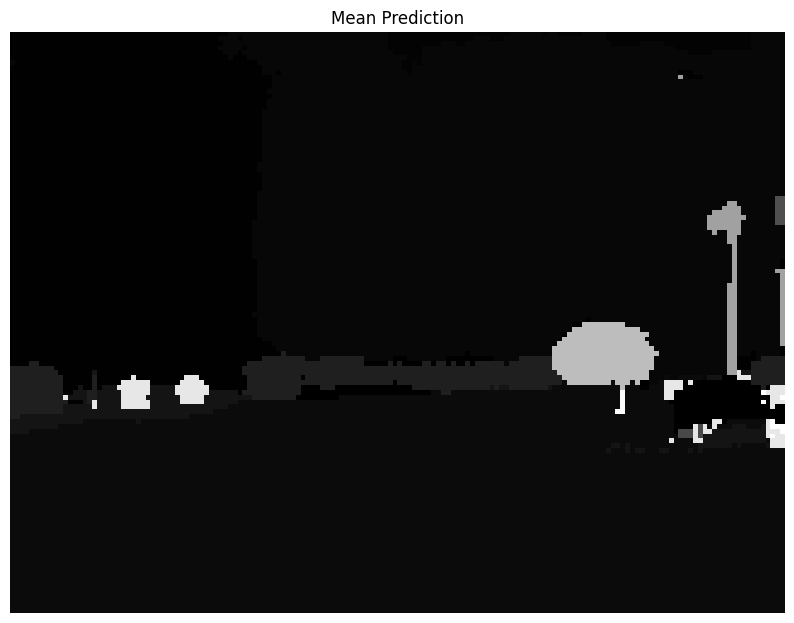

In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assume mean_prediction, variance, and entropy are obtained from the previous steps

def normalize(tensor):
    """ Normalize tensor to range [0, 1] """
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    return normalized_tensor

def visualize_uncertainty(uncertainty_mask, title="Uncertainty Mask"):
    """ Visualize the uncertainty mask """
    # Convert tensor to numpy array
    uncertainty_mask = uncertainty_mask.cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    uncertainty_mask_plot=processor.post_process_semantic_segmentation(outputs, target_sizes=[[720,1280]])[0]
    uncertainty_mask_plot = uncertainty_mask_plot.cpu().numpy()
    plt.imshow(uncertainty_mask_plot, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

# Normalize the uncertainty values
normalized_variance = normalize(variance)
normalized_entropy = normalize(entropy)

# Visualize the uncertainty masks
visualize_uncertainty(normalized_variance, title="Uncertainty Mask (Variance)")
visualize_uncertainty(normalized_entropy, title="Uncertainty Mask (Entropy)")

# Optionally, visualize the mean prediction as well
mean_prediction_np = mean_prediction.argmax(dim=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(mean_prediction_np[0], cmap='gray', interpolation='nearest')
plt.title("Mean Prediction")
plt.axis('off')
plt.show()


In [41]:
print(logits.shape)

torch.Size([1, 150, 120, 160])


In [42]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [43]:

predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[[image.shape[0],image.shape[1]]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 ...
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]]


In [44]:
from collections import defaultdict

def find_frequent_elements(matrix):
    # Initialize a dictionary to keep track of the count of each element
    count_dict = defaultdict(int)
    
    # Flatten the 2D array and count each element
    for row in matrix:
        for num in row:
            count_dict[num] += 1
    
    # Find all elements that occur more than 100 times
    frequent_elements = [num for num, count in count_dict.items() if count > 100]
    
    # Print the result
    print(frequent_elements)
    
find_frequent_elements(predicted_segmentation_map)

[1, 4, 2, 87, 43, 102, 17, 0, 11, 125, 6, 40]


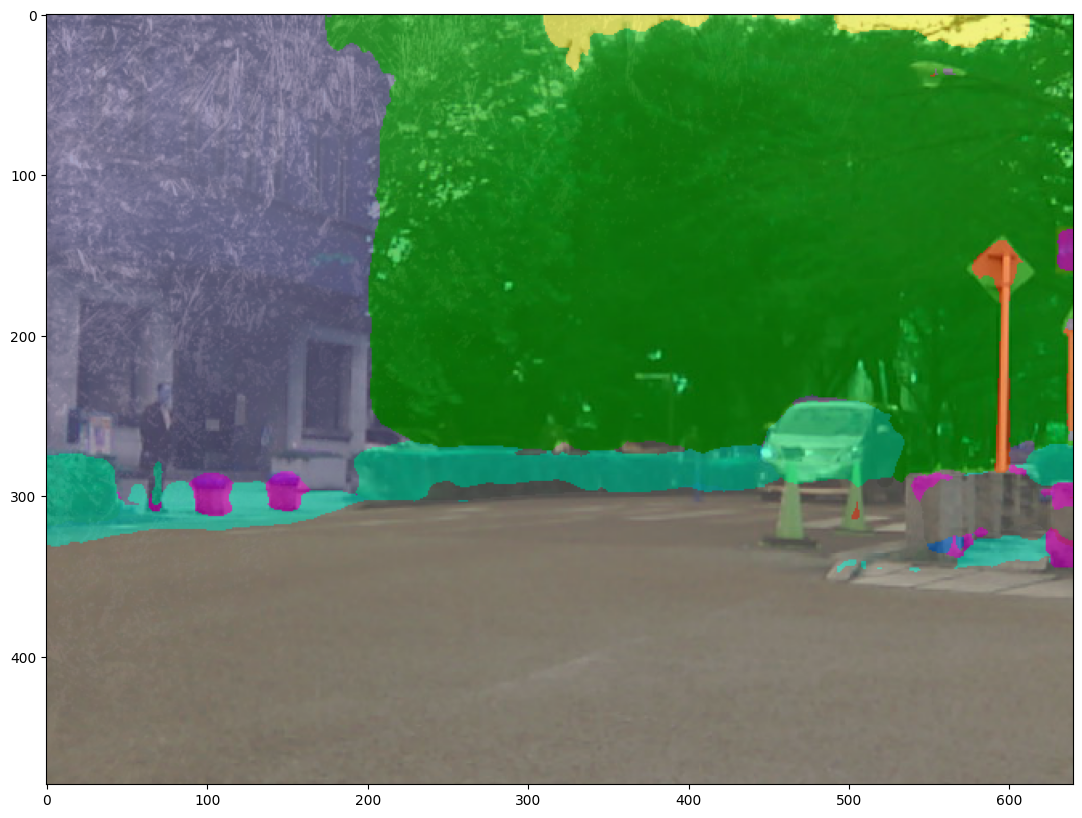

In [45]:
import matplotlib.pyplot as plt
import numpy as np
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [14]:
import numpy as np

# Assuming logits is a NumPy array
logits = np.array([logits.cpu()])  # replace logits_array with your actual logits array

